In [1]:
import gradio as gr
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import StoppingCriteria, StoppingCriteriaList, TextIteratorStreamer
from threading import Thread
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
import torch.nn as nn
import inspect
import torch.multiprocessing as mp
mp.set_start_method('spawn')

ModuleNotFoundError: No module named 'gradio'

In [2]:
# https://huggingface.co/blog/llama2#using-transformers


tiny_llama = "/mnt/xue.w/models/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/77e23968eed12d195bd46c519aa679cc22a27ddc"
llama_7b_hf_chat = "/mnt/xue.w/models/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/c1b0db933684edbfe29a06fa47eb19cc48025e93"
# code_llama_70 = '/mnt/xue.w/models/hub/models--codellama--CodeLlama-70b-hf/snapshots/4570a4edc524fb9f20f605b417bb43828fa5997a'

miqu_70b ='/mnt/xue.w/models/hub/models--miqudev--miqu-1-70b/models--miqudev--miqu-1-70b/snapshots/82f0daa6767263aa5990dea54dbb13e94d096de7'
Mixtral_8x7b_instruct ='/mnt/xue.w/models/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a'

model_pth = llama_7b_hf_chat

# setting softprompt model wrapper
# class SoftPromptWrapper():
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#         self.soft_prompt = None

#     def set_soft_prompt(self, soft_prompt):
#         self.soft_prompt = soft_prompt

#     def forward(self, input_ids, **kwargs):
#         if self.soft_prompt is not None:
#             input_embeds = self.model.gt_input_embeddings()(input_ids)  
#             input_embeds = torch.cat([input_embeds, self.soft_prompt], dim=1)
#             input_ids = None
#             kwargs["inputs_embeds"] = input_embeds
#         return self.model(input_ids, **kwargs)
    
#     def generate(self, **kwargs):
#         # add softprompt to kwargs
#         if self.soft_prompt is not None:
#             if "input_ids" in kwargs:
#                 input_embeds = self.model.get_input_embeddings()(kwargs["input_ids"])  
#                 input_embeds = torch.cat([input_embeds, self.soft_prompt], dim=1)
#                 kwargs["inputs_embeds"] = input_embeds
#                 kwargs["input_ids"] = None
#             else:
#                 kwargs["inputs_embeds"] = self.soft_prompt
#         return self.model.generate(**kwargs)
    


    
        
# Loading the tokenizer and model from local path.
# tokenizer = AutoTokenizer.from_pretrained(model_pth,torch_dtype=torch.float16,device_map="auto",load_in_4bit=False,load_in_8bit=False)
# model = AutoModelForCausalLM.from_pretrained(model_pth,torch_dtype=torch.float16,device_map="auto",load_in_4bit=False,load_in_8bit=False)
tokenizer = AutoTokenizer.from_pretrained(model_pth,torch_dtype=torch.float16,load_in_4bit=False,load_in_8bit=False)
model = AutoModelForCausalLM.from_pretrained(model_pth,torch_dtype=torch.float16,load_in_4bit=False,load_in_8bit=False)

# model = SoftPromptWrapper(model)

# get token embedding dimension
# embed_dim = model.model.get_input_embeddings().embedding_dim
# print(f"Embedding dimension: {embed_dim}")    # 4096

# set soft prompt
soft_prompt = model.get_input_embeddings()(tokenizer("In this conversation, the user is asking the assistant for help with a coding problem. The assistant should provide a helpful response.", return_tensors="pt").input_ids)
# model.set_soft_prompt(soft_prompt)

# using CUDA for an optimal experience
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        stop_ids = [2]  # IDs of tokens where the generation should stop.
        for stop_id in stop_ids:
            if input_ids[0][-1] == stop_id:  # Checking if the last generated token is a stop token.
                return True
        return False
    
class BatchedStopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        stop_ids = [2]  # IDs of tokens where the generation should stop.
        for stop_id in stop_ids:
            # checking if stop token appears in every batch (not just the last token)
            if (input_ids == stop_id).any(dim=-1).all():
                return True
            # check if stop token is generated in all batches
            # if all([input_id[-1] == stop_id for input_id in input_ids]):
            #     return True
        return False


# Function to generate model predictions.
def predict(message,history = []):
    history_transformer_format = history + [[message, ""]]
    stop = StopOnTokens()

    # Formatting the input for the model.
    messages = "</s>".join(["</s>".join(["\n<|user|>:" + item[0], "\n<|assistant|>:" + item[1]])
                        for item in history_transformer_format])
    model_inputs = tokenizer([messages], return_tensors="pt")
    # .to(device)
    streamer = TextIteratorStreamer(tokenizer, timeout=10., skip_prompt=True, skip_special_tokens=True)
    generate_kwargs = dict(
        model_inputs,
        streamer=streamer,
        max_new_tokens=1024,
        do_sample=True,
        top_p=0.95,
        top_k=50,
        temperature=0.7,
        num_beams=1,
        stopping_criteria=StoppingCriteriaList([stop])
    )
    t = Thread(target=model.generate, kwargs=generate_kwargs)
    t.start()  # Starting the generation in a separate thread.
    partial_message = ""
    for new_token in streamer:
        partial_message += new_token
        if '</s>' in partial_message:  # Breaking the loop if the stop token is generated.
            break
    yield partial_message
    # return partial_message

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


In [3]:
# softprompt training in gsm8k dataset
import re
import json
import concurrent.futures
from tqdm import tqdm
embedding_dim = 4096

ANS_RE = re.compile(r"#### (\-?[0-9\.\,]+)")
def extract_answer(completion):
    match = ANS_RE.search(completion)
    if match:
        match_str = match.group(1).strip()
        match_str = match_str.replace(",", "")
        return match_str
    else:
        return "[invalid]"

def compute_loss(model, tokenizer, sys_prompt, soft_prompt, data, device):

    batch_size = len(data)
    total_loss = 0
    with torch.no_grad():
        for datum in data:
            question, answer = datum['question'], datum['answer']
            streamer = TextIteratorStreamer(tokenizer, timeout=10., skip_prompt=True, skip_special_tokens=True)
            stop = StopOnTokens()
            input_prompt = "<|system|>:" + sys_prompt + "</s>" + "\n<|user|>:" + question + "</s>" + "\n<|assistant|>:"
            inputs_embeds = torch.cat([soft_prompt.to(device), model.get_input_embeddings()(tokenizer(input_prompt, return_tensors="pt").input_ids.to(device))], dim=1)
            generate_kwargs = dict(
                inputs_embeds=inputs_embeds,
                streamer=streamer,
                max_new_tokens=1024,
                do_sample=True,
                top_p=0.95,
                top_k=50,
                temperature=0.7,
                num_beams=1,
                stopping_criteria=StoppingCriteriaList([stop])
            )
            model.generate(**generate_kwargs)
            output = ""
            for new_token in streamer:
                output += new_token
                if '</s>' in output:
                    break
            true_ans = float(extract_answer(answer))
            # print(output)
            ans = extract_answer(output)
            if ans == "[invalid]":
                loss = torch.tensor(1.0)
            else:
                ans = float(ans)
                if ans == 0 and true_ans == 0:
                    loss = 0
                else:
                    loss = torch.abs(torch.tensor(ans - true_ans)) / (torch.abs(torch.tensor(true_ans)) + torch.abs(torch.tensor(ans)))
            total_loss += loss
    return (total_loss / batch_size).detach()

def compute_loss_batched(model, tokenizer, sys_prompt, soft_prompt, data, batchsize, device, use_tqdm=False):

    n_data = len(data)
    n_batches = n_data // batchsize
    total_loss = 0
    if use_tqdm:
        pbar = tqdm(total=n_data, desc=f"Computing loss on {device}", ncols=80)
    for i in range(n_batches):
        batch_data = data[i*batchsize:(i+1)*batchsize]
        questions = [datum['question'] for datum in batch_data]
        # answers = [datum['answer'] for datum in batch_data]
        stop = BatchedStopOnTokens()
        input_prompts = ["<|system|>:" + sys_prompt + "</s>" + "\n<|user|:" + question + "</s>" + "\n<|assistant|>:" for question in questions]
        # tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token = tokenizer.bos_token
        # adding softprompt to each embedded input
        inputs_embeds = []
        for j in range(len(input_prompts)):
            inputs_embeds.append(torch.cat([soft_prompt.to(device), model.get_input_embeddings()(tokenizer(input_prompts[j], return_tensors="pt", padding=False, truncation=True, max_length=512).input_ids.to(device))], dim=1))
        # get the max length of the inputs_embeds
        max_len = max([inputs_embed.size(1) for inputs_embed in inputs_embeds])
        # padding each input_embeds to the max length with tokenizer.pad_token_id on the left
        bos_token_embed = model.get_input_embeddings()(torch.tensor(tokenizer.bos_token_id, device=device)).unsqueeze(0).unsqueeze(0).to(device)
        attention_mask = []
        for j in range(len(inputs_embeds)):
            padding_len = max_len - inputs_embeds[j].size(1)
            padding = bos_token_embed.repeat(1, padding_len, 1)
            inputs_embeds[j] = torch.cat([padding, inputs_embeds[j]], dim=1)
            attention_mask.append(torch.cat([torch.zeros(padding_len, device=device), torch.ones(inputs_embeds[j].size(1) - padding_len, device=device)]).unsqueeze(0))
            # inputs_embeds[j] = nn.functional.pad(inputs_embeds[j], (0, 0, max_len - inputs_embeds[j].size(1), 0), value=tokenizer.pad_token_id)
            # print(inputs_embeds[j].size())
        # transfer to tensor
        inputs_embeds = torch.concatenate(inputs_embeds, dim=0)
        attention_mask = torch.concatenate(attention_mask, dim=0)
        # print(inputs_embeds)
        # print(inputs_embeds.size())
        # padding side is left
        # tokenizer.padding_side = "left"
        # pad the inputs_embeds to match the batch dimension
        # inputs_embeds = tokenizer.pad(inputs_embeds, return_tensors="pt", padding=True, max_length=512)
        # copy softprompt to match the batch dimension
        # soft_prompt = soft_prompt.repeat(len(input_prompts), 1, 1)
        # inputs_embeds = torch.cat([soft_prompt.to(device), model.get_input_embeddings()(tokenizer(input_prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).input_ids.to(device))], dim=1)
        generate_kwargs = dict(
            inputs_embeds=inputs_embeds,
            max_new_tokens=1024,
            do_sample=True,
            top_p=0.95,
            top_k=50,
            temperature=0.7,
            num_beams=1,
            stopping_criteria=StoppingCriteriaList([stop]),
            attention_mask=attention_mask
        )
        outputs = model.generate(**generate_kwargs)
        for j in range(outputs.size(0)):
            if tokenizer.eos_token_id in outputs[j]:
                eos_index = (outputs[j] == tokenizer.eos_token_id).nonzero()[0].item()
                outputs[j, eos_index+1:] = tokenizer.pad_token_id
        output_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        # print('\n'.join(output_texts))
        for j, output in enumerate(output_texts):
            true_ans = float(extract_answer(batch_data[j]['answer']))
            ans = extract_answer(output)
            if ans == "[invalid]":
                loss = torch.tensor(1.0)
            else:
                try: # 防止逆天输出'33.333...'
                    ans = float(ans) 
                except:
                    total_loss += torch.tensor(1.0)
                    continue
                if ans == 0 and true_ans == 0:
                    loss = torch.tensor(0.0)
                else:
                    loss = torch.abs(torch.tensor(ans - true_ans)) / (torch.abs(torch.tensor(true_ans)) + torch.abs(torch.tensor(ans)))
            total_loss += loss
        if use_tqdm:
            pbar.update(batchsize)
    if use_tqdm:
        pbar.close()
    return (total_loss / n_data).detach()


def compute_loss_concurrent(models, tokenizers, sys_prompt, soft_prompt, data, batch_size=4, n_GPU=4, use_tqdm=False):

    n_data = len(data)
    batchsize_per_GPU = n_data // n_GPU

    # n_data = len(data)
    # n_batches = n_data // n_GPU
    # if n_data % n_GPU != 0:
    #     n_batches += 1
    total_loss = 0
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(n_GPU):
            futures.append(executor.submit(compute_loss_batched, models[i], tokenizers[i], sys_prompt, soft_prompt, data[i*batchsize_per_GPU:(i+1)*batchsize_per_GPU], batch_size, torch.device(f'cuda:{i}'), use_tqdm=(use_tqdm and i == 0)))
        # futures = executor.map(lambda i: compute_loss(model, sys_prompt, soft_prompt, data[i*n_batches:(i+1)*n_batches]), range(batch_size))
        for future in concurrent.futures.as_completed(futures):
            total_loss += future.result()
    return total_loss / n_GPU

# def compute_loss_concurrent(models, tokenizers, sys_prompt, soft_prompt, data, batch_size=4):

#     n_data = len(data)
#     n_batches = n_data // batch_size
#     if n_data % batch_size != 0:
#         n_batches += 1
#     total_loss = 0

#     # Create a pool of processes
#     with mp.Pool(processes=batch_size) as pool:
#         results = []
#         for i in range(batch_size):
#             # Use the model that is already on the correct device
#             model = models[i]
#             tokenizer = tokenizers[i]
#             batch_data = data[i*n_batches:(i+1)*n_batches]
#             # batch_data = [datum.to(device) for datum in batch_data]
#             soft_prompt = soft_prompt.to(device).detach()
#             # Compute loss in a separate process
#             result = pool.apply_async(compute_loss, (model, tokenizer, sys_prompt, soft_prompt, batch_data))
#             results.append(result)

#         # Get the results
#         for result in results:
#             total_loss += result.get()

#     return total_loss / batch_size

def compute_loss_concurrent_globaled_model(sys_prompt, soft_prompt, data, batch_size=4):

    n_data = len(data)
    n_batches = n_data // batch_size
    if n_data % batch_size != 0:
        n_batches += 1
    total_loss = 0

    # Create a pool of processes
    with mp.Pool(processes=batch_size) as pool:
        results = []
        for i in range(batch_size):
            # Use the model that is already on the correct device
            batch_data = data[i*n_batches:(i+1)*n_batches]
            # batch_data = [datum.to(device) for datum in batch_data]
            soft_prompt = soft_prompt.to(device).detach()
            # Compute loss in a separate process
            result = pool.apply_async(compute_loss, (sys_prompt, soft_prompt, batch_data))
            results.append(result)

        # Get the results
        for result in results:
            total_loss += result.get()

    return total_loss / batch_size

# def soft_prompt_training_gsm8k(model, n_tokens, sys_prompt, soft_prompt_init, training_data):

#     # Initialize the soft prompt
#     if soft_prompt_init is None:
#         soft_prompt = torch.randn(1, n_tokens, embedding_dim)
#     else:
#         soft_prompt = torch.tensor(soft_prompt_init).to(device)
    
#     for data in training_data:

#         question, answer = data['question'], data['answer']
#         # print('question:', question)
#         # print('answer:', answer)
#         streamer = TextIteratorStreamer(tokenizer, timeout=10., skip_prompt=True, skip_special_tokens=True)
#         stop = StopOnTokens()

#         # generate input prompts
#         input_prompt = "<|system|>:" + sys_prompt + "</s>" + "\n<|user|>:" + question + "</s>" + "\n<|assistant|>:"
#         # generate inputs_embeds
#         # print('input_prompt:', input_prompt)
#         # inputs_embeds = torch.cat([soft_prompt, model.get_input_embeddings()(tokenizer(input_prompt, return_tensors="pt").input_ids)], dim=1)
#         inputs_embeds = model.get_input_embeddings()(tokenizer(input_prompt, return_tensors="pt").input_ids)
#         # generate outputs
#         generate_kwargs = dict(
#             inputs_embeds=inputs_embeds,
#             streamer=streamer,
#             max_new_tokens=1024,
#             do_sample=True,
#             top_p=0.95,
#             top_k=50,
#             temperature=0.7,
#             num_beams=1,
#             stopping_criteria=StoppingCriteriaList([stop])
#         )
#         model.generate(**generate_kwargs)
#         # check output
#         output = ""
#         for new_token in streamer:
#             output += new_token
#             if '</s>' in output:
#                 break
#         # print(output)
#         # get answer digits by finding "/n####"
#         true_ans = float(extract_answer(answer))
#         ans = extract_answer(output)
#         if ans == "[invalid]":
#             loss = torch.tensor(1.0)
#         else:
#             ans = float(ans)
#             if ans == 0 and true_ans == 0:
#                 loss = 0
#             else:
#                 loss = torch.abs(torch.tensor(ans - true_ans)) / (torch.abs(torch.tensor(true_ans)) + torch.abs(torch.tensor(ans)))
#         print('LLaMA ans:', ans)
#         print('true ans:', true_ans)
#         print('loss:', loss)

#     return soft_prompt

with open('/mnt/yutong/data/grade_school_math/data/test.jsonl', 'r') as f:
    data_test = f.readlines()
    data_test = [json.loads(d) for d in data_test]

with open('/mnt/yutong/data/grade_school_math/data/train.jsonl', 'r') as f:
    data_train = f.readlines()
    data_train = [json.loads(d) for d in data_train]

# n_tokens = 10
# # sys_prompt = "You are a math problem solving assistant. Given the question, you should use your best capability to solve it and provide the answer. After providing the solution, you must add a straightforward answer of format '\n#### <number>' in the end of your response. The <number> should only contain a number and '\n#### <number>' must match the following regular expression: '\n#### (\-?[0-9\.\,]+)'."
# # sys_prompt = "You are a math problem solving assistant. Given the question, you should use your best capability to solve it and provide the answer. After providing the solution, you must add a straightforward answer of format '\n#### <number>' in the end of your response. The <number> should be pure number consists of '-', '0'-'9', '.', ',', WITHOUT any other tokens representing the answer's unit. Note that '26' is a valid <number> and '/$26' is not. For example, '\n#### /$18' is NOT a valid answer and must be modified to '\n#### 18'. NOTE: You've failed a lot of trials before, because of extra explantory words after the answer region '\n#### <number>' or a wrong <number> syntax as '\$24'. Please make sure the answer is the last token in your response."
# sys_prompt = "Solving the follwing math problem and response with '\n#### <answer>' with <answer> substituted by the correct number in the very end:\n"
# soft_prompt_init = torch.randn(1, n_tokens, embedding_dim).to(device)
# soft_prompt_training_gsm8k(peft_model, n_tokens, sys_prompt, soft_prompt_init, data_test[:50])

In [4]:
print(len(data_test))
print(len(data_train))

1319
7473


In [5]:
import copy
n_tokens = 10
sys_prompt = "Solving the following math problem and respond with '\n#### <answer>' with <answer> substituted by the correct number in the very end:\n"
models = [copy.deepcopy(model).to(torch.device(f'cuda:{_}')) for _ in range(4)]

# soft_prompt_init = torch.randn(1, n_tokens, embedding_dim, dtype=torch.float16).to(device)
soft_prompt_init = model.get_input_embeddings()(tokenizer("1+1=?", return_tensors="pt").input_ids)
tokenizers = [AutoTokenizer.from_pretrained(model_pth,torch_dtype=torch.float16,load_in_4bit=False,load_in_8bit=False) for _ in range(3)] + [tokenizer]

In [6]:
from peft import PeftModel

peft_model_id = "llama_2_7b_lora_2/1_epoch_finetuning"
# peft_model_id = "llama_2_7b_lora_3/5_epoch_finetuning"
# peft_model_id = "llama_2_7b_lora_3/checkpoint-1000"
peft_models = [PeftModel.from_pretrained(models[i], peft_model_id, torch_dtype=torch.float16) for i in range(4)]

In [7]:
import os

os.environ['TOKENIZERS_PARALLELISM'] = "false"

In [8]:
import concurrent.futures

def zero_order_softprompt_tuning_twopoints(model, sys_prompt, soft_prompt, training_data, validation_data, batchsize, maxIters, learning_rate, variation_scale):
    # get batched data
    batched_data = [training_data[i:i+batchsize] for i in range(0, len(training_data), batchsize)]
    # compute parameters in soft_prompt
    dimension = soft_prompt.numel()
    for i in range(maxIters):
        # get initial loss
        loss = compute_loss(model, sys_prompt, soft_prompt, batched_data[i])
        # random variation in softprompt as uniform unit ball distribution
        random_directions = torch.randn_like(soft_prompt)
        random_directions = random_directions / torch.norm(random_directions)
        random_variations = random_directions * variation_scale
        # get variation sampling
        soft_prompt_plus = soft_prompt + random_variations
        loss_plus = compute_loss(model, sys_prompt, soft_prompt_plus, batched_data[i])
        # get loss difference
        loss_diff = loss_plus - loss
        # compute zero-order gradient
        gradient = (loss_diff / variation_scale * dimension) * random_directions
        # update softprompt
        soft_prompt = soft_prompt - learning_rate * gradient
        # validation
        validation_loss = compute_loss(model, sys_prompt, soft_prompt, validation_data)
        print(f"Iteration {i}: Validation loss {validation_loss}")
    return soft_prompt

def zero_order_softprompt_tuning_twopoints_concurrent(models, tokenizers, sys_prompt, soft_prompt, training_data, validation_data, batchsize, maxIters, learning_rate, variation_scale):
    # get batched data
    batched_data = [training_data[i:i+batchsize] for i in range(0, len(training_data), batchsize)]
    # compute parameters in soft_prompt
    dimension = soft_prompt.numel()
    for i in range(maxIters):
        # get initial loss
        loss = compute_loss_concurrent(models, tokenizers, sys_prompt, soft_prompt, batched_data[i], batch_size=batchsize//4, n_GPU=4)
        print(f'loss:{loss}')
        # random variation in softprompt as uniform unit ball distribution
        random_directions = torch.randn_like(soft_prompt)
        random_directions = random_directions / torch.norm(random_directions)
        random_variations = random_directions * variation_scale
        # get variation sampling
        soft_prompt_plus = soft_prompt + random_variations
        loss_plus = compute_loss_concurrent(models, tokenizers, sys_prompt, soft_prompt_plus, batched_data[i], batch_size=batchsize//4, n_GPU=4)
        print(f'loss_plus:{loss_plus}')
        # get loss difference
        loss_diff = loss_plus - loss
        # compute zero-order gradient
        gradient = (loss_diff / variation_scale * (dimension * learning_rate)) * random_directions
        # update softprompt
        soft_prompt = soft_prompt - gradient
        # validation
        validation_loss = compute_loss_concurrent(models, tokenizers, sys_prompt, soft_prompt, validation_data, batch_size=batchsize//4, n_GPU=4)
        print(f"Iteration {i}: Validation loss {validation_loss}")
    return soft_prompt

def zero_order_softprompt_tuning_twopoints_concurrent_globaled_model(sys_prompt, soft_prompt, training_data, validation_data, batchsize, maxIters, learning_rate, variation_scale):
    # get batched data
    batched_data = [training_data[i:i+batchsize] for i in range(0, len(training_data), batchsize)]
    # compute parameters in soft_prompt
    dimension = soft_prompt.numel()
    for i in range(maxIters):
        # get initial loss
        loss = compute_loss_concurrent_globaled_model(sys_prompt, soft_prompt, batched_data[i], batch_size=4)
        # random variation in softprompt as uniform unit ball distribution
        random_directions = torch.randn_like(soft_prompt)
        random_directions = random_directions / torch.norm(random_directions)
        random_variations = random_directions * variation_scale
        # get variation sampling
        soft_prompt_plus = soft_prompt + random_variations
        loss_plus = compute_loss_concurrent_globaled_model(sys_prompt, soft_prompt_plus, batched_data[i], batch_size=4)
        # get loss difference
        loss_diff = loss_plus - loss
        # compute zero-order gradient
        gradient = (loss_diff / variation_scale * dimension) * random_directions
        # update softprompt
        soft_prompt = soft_prompt - learning_rate * gradient
        # validation
        validation_loss = compute_loss_concurrent_globaled_model(sys_prompt, soft_prompt, validation_data, batch_size=4)
        print(f"Iteration {i}: Validation loss {validation_loss}")
    return soft_prompt

In [9]:
# from peft import PeftModel
# peft_model_id = "llama_2_7b_lora_2/1_epoch_finetuning"

# def init_worker():
#     global model, tokenizer
#     model = AutoModelForCausalLM.from_pretrained(model_pth,torch_dtype=torch.float16,load_in_4bit=False,load_in_8bit=False)
#     tokenizer = AutoTokenizer.from_pretrained(model_pth,torch_dtype=torch.float16,load_in_4bit=False,load_in_8bit=False)
#     model = PeftModel.from_pretrained(model, peft_model_id, torch_dtype=torch.float16)
# set random seed
import torch
torch.manual_seed(0)
import random
random.seed(0)

# load softprompt
soft_prompt_path = 'softprompt_tuning/softprompt_epoch_5.pt'
soft_prompt = torch.load(soft_prompt_path)

# loss = compute_loss_batched(peft_models[0], tokenizers[0], sys_prompt, soft_prompt, data_test[:1312], 2, torch.device('cuda:0'))
loss = compute_loss_concurrent(peft_models, tokenizers, sys_prompt, soft_prompt, data_test[:1312], 32, 4, use_tqdm=True)
# 进度条
# loss = compute_loss_concurrent(peft_models, tokenizers, sys_prompt, soft_prompt, data_train[:7456], 32, 4, use_tqdm=True)
print(loss)

Computing loss on cuda:0:  98%|██████████████▋| 320/328 [16:59<00:25,  3.19s/it]


tensor(0.4157)


llama_2_7b_lora_2/1_epoch_finetuning loss: 0.4157(test), 0.xxxx(train); acc: 0.1616(test)

llama_2_7b_lora_3/5_epoch_finetuning loss: 0.2827(test), 0.2374(train); acc: 0.3148(test)

softprompt_tuning/softprompt_epoch_1: 0.2891(test), 0.2336(train); acc: 0.2896(test)

softprompt_tuning/softprompt_epoch_2: 0.2862(test), 0.xxxx(train); acc: 0.3041(test)

softprompt_tuning/softprompt_epoch_3: 0.2906(test),

softprompt_tuning/softprompt_epoch_4: 0.2845(test),

softprompt_tuning/softprompt_epoch_5: 0.2846(test),

In [10]:
import torch
torch.manual_seed(0)
import random
random.seed(0)
# zero_order_softprompt_tuning_twopoints_concurrent(peft_models, tokenizers, sys_prompt, soft_prompt_init, data_train[:320], data_test[50:82], batchsize=32, maxIters=10, learning_rate=1e-7, variation_scale=1e-2)

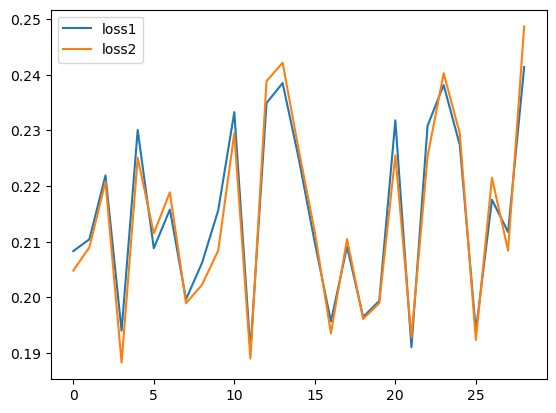

In [2]:
import pickle
import matplotlib.pyplot as plt

# pth = './results/tzo_adam_spt_lr_1e-07_vs_0.001'
# pth = './results/tzo_proj_msgd_spt_lr_1e-06_vs_0.001_mo_0.9_wd_0.01_tokendim_7'
pth = './results/tzo_msgd_spt_det_lr_1e-06_vs_0.001_mo_0.9_wd_0.01'
with open(pth + '/logs.pt', 'rb') as f:
    logs = pickle.load(f)

plt.plot(logs['loss1'], label='loss1')
plt.plot(logs['loss2'], label='loss2')
plt.legend()
plt.show()

In [4]:
import torch
# 生成随机投影矩阵


torch.Size([1, 10, 10]) torch.Size([1, 10]) torch.Size([1, 4096, 10])


In [1]:
import torch
import matplotlib.pyplot as plt

# pth = './results/tzo_adam_spt_lr_1e-07_vs_0.001'
pth = './results/tzo_msgd_spt_det_lr_1e-05_vs_0.001_mo_0.9_wd_0.01'
soft_prompt = torch.load(pth + '/softprompt_epoch_1.pt')
soft_prompt_16 = torch.tensor(soft_prompt, dtype=torch.float16)
soft_prompt_init = torch.load('./softprompt_init.pt')
print((soft_prompt_init == soft_prompt_16).all())
print(torch.norm(soft_prompt_16 - soft_prompt))
print(torch.norm(soft_prompt_16)**2 / torch.numel(soft_prompt_16))
print(torch.norm(soft_prompt_init)**2 / torch.numel(soft_prompt_init))

KeyboardInterrupt: 

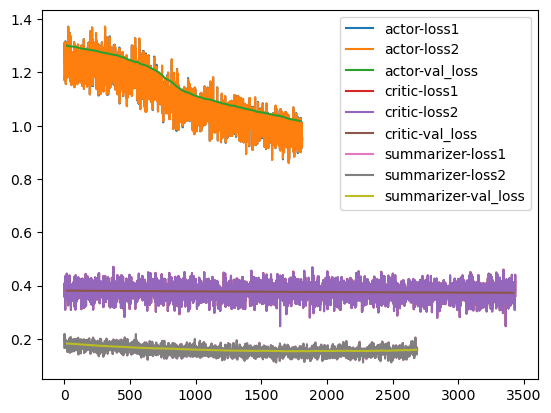

In [9]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
with open('./finetuned_models/actor_llama3_lora/zo_eps_0.001_lr_0.0001_fp16_epoch_2/logs.pkl', 'rb') as f:
    logs = pickle.load(f)
    loss1, loss2, val_loss = logs['loss1'], logs['loss2'], logs['val_loss']
    plt.plot(loss1, label='actor-loss1')
    plt.plot(loss2, label='actor-loss2')
    # print(len(loss1), len(val_loss))
    plt.plot(np.arange(20, len(loss1), 20), val_loss, label='actor-val_loss')
    plt.legend()
with open('./finetuned_models/critic_llama3_lora/zo_eps_0.001_lr_0.0001_fp16_epoch_2/logs.pkl', 'rb') as f:
    logs = pickle.load(f)
    loss1, loss2, val_loss = logs['loss1'], logs['loss2'], logs['val_loss']
    plt.plot(loss1, label='critic-loss1')
    plt.plot(loss2, label='critic-loss2')
    # print(len(loss1), len(val_loss))
    plt.plot(np.arange(20, len(loss1), 20), val_loss, label='critic-val_loss')
    plt.legend()
with open('./finetuned_models/summarizer_llama3_lora/zo_eps_0.001_lr_0.001_fp16_epoch_2/logs.pkl', 'rb') as f:
    logs = pickle.load(f)
    loss1, loss2, val_loss = logs['loss1'], logs['loss2'], logs['val_loss']
    plt.plot(loss1, label='summarizer-loss1')
    plt.plot(loss2, label='summarizer-loss2')
    # print(len(loss1), len(val_loss))
    plt.plot(np.arange(20, len(loss1), 20), val_loss, label='summarizer-val_loss')
    plt.legend()

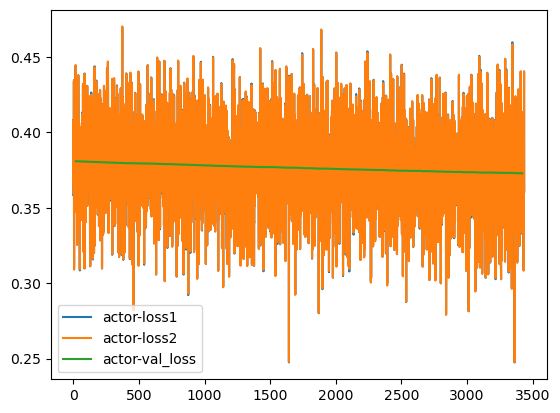

In [6]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
with open('./finetuned_models/critic_llama3_lora/zo_eps_0.001_lr_0.0001_fp16_epoch_2/logs.pkl', 'rb') as f:
    logs = pickle.load(f)
    loss1, loss2, val_loss = logs['loss1'], logs['loss2'], logs['val_loss']
    plt.plot(loss1, label='actor-loss1')
    plt.plot(loss2, label='actor-loss2')
    # print(len(loss1), len(val_loss))
    plt.plot(np.arange(20, len(loss1), 20), val_loss, label='actor-val_loss')
    plt.legend()

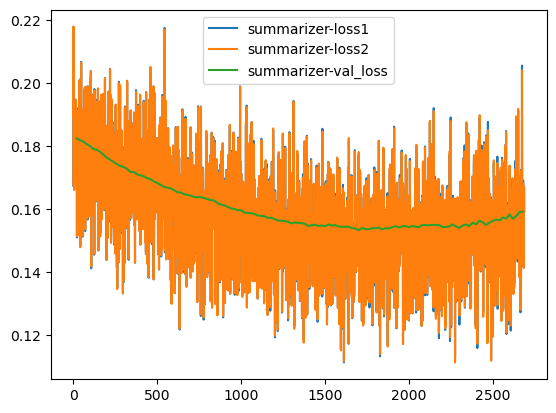

In [10]:
with open('./finetuned_models/summarizer_llama3_lora/zo_eps_0.001_lr_0.001_fp16_epoch_2/logs.pkl', 'rb') as f:
    logs = pickle.load(f)
    loss1, loss2, val_loss = logs['loss1'], logs['loss2'], logs['val_loss']
    plt.plot(loss1, label='summarizer-loss1')
    plt.plot(loss2, label='summarizer-loss2')
    # print(len(loss1), len(val_loss))
    plt.plot(np.arange(20, len(loss1), 20), val_loss, label='summarizer-val_loss')
    plt.legend()